In [53]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from temperature_scaling_tensorflow import TemperatureScaling, expected_calibration_error
import tensorflow as tf
from typing import cast

In [54]:
# Load the cifar10-Dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

# Reshape y_train to (50000, )
y_train = y_train.reshape(-1)

# Split the dataset
x_train_new, x_val, y_train_new, y_val = train_test_split(
    x_train,
    y_train,
    test_size=0.2,
    random_state=42,
)

In [55]:
# Load the pretrained model
model_logits = tf.keras.models.load_model("best_model_logits.keras")

# Evaluate the model
test_loss, test_acc = model_logits.evaluate(x_test, y_test)
print(f"test_loss: {test_loss}, test_acc: {test_acc}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 1.1314 - sparse_categorical_accuracy: 0.8028
test_loss: 1.1314232349395752, test_acc: 0.8027999997138977


In [56]:
tes1 = TemperatureScaling(model_logits)
tes1.set_temperature(x_val, y_val)
x_test_predicted = tes1.predict(x_test, True).numpy()

x_test_before = model_logits(x_test, training=False).numpy()
x_test_before = tf.nn.softmax(x_test_before, axis=-1).numpy()

In [57]:
ece_before = expected_calibration_error(x_test_before, y_test.flatten())
ece_after = expected_calibration_error(x_test_predicted, y_test.flatten())
print(f"ECE before calibration: {ece_before:.3f}")
print(f"ECE after calibration : {ece_after:.3f}")

ECE before calibration: 0.141
ECE after calibration : 0.007


In [58]:
x_test_before.shape

(10000, 10)

In [62]:
def compute_reliability_diagram(probabilities: np.ndarray, labels: np.ndarray, n_bins: int = 10) -> dict:
    """Calculates the bins for a reliability diagram.

    Args:
        probabilities: The probabilities from the model
        labels: The labels corresponding to the probabilities
        n_bins: The number of bins the intervall [0, 1] should be divided into

    Returns:
        diagram: An dict object of the form ["n_bins"]["bin_accuracies"]["bin_confidences"]["bin_counts"]
        where
            - ["n_bins contains"] the number of bins
            - ["bin_accuracies"] contains the mean accuracies for all bins
            - ["bin_confidences"] contains the mean confidences for all bins
            - ["bin_counts"] contains the number of predictions in every bin
    """
    diagram = {"n_bins": n_bins, "bin_accuracies": [], "bin_confidences": [], "bin_counts": []}
    labels = labels.reshape(-1)

    bins = np.linspace(0.0, 1.0, n_bins + 1)
    predictions = np.argmax(probabilities, axis=1)
    confidences = np.max(probabilities, axis=1)

    bin_indices = np.digitize(confidences, bins) - 1
    bin_indices = np.clip(bin_indices, 0, n_bins - 1)

    for b in range(n_bins):
        indices = np.where(bin_indices == b)[0]

        if len(indices) == 0:
            cast("list", diagram["bin_accuracies"]).append(np.float64(0.0))
            cast("list", diagram["bin_confidences"]).append(np.float64(0.0))
            cast("list", diagram["bin_counts"]).append(0)
            continue

        accuracy = np.mean(predictions[indices] == labels[indices])
        confidence = np.mean(confidences[indices])

        cast("list", diagram["bin_accuracies"]).append(accuracy)
        cast("list", diagram["bin_confidences"]).append(confidence)
        cast("list", diagram["bin_counts"]).append(len(indices))

    return diagram
    
def plot_reliability_diagram(diagram: dict, title: str = "Model Calibration") -> tuple[plt.figure, plt.axes] :
    """Plots the diagram calculated with `compute_reliability_diagram`.

    Args:
        diagram: A dictionary containing the fields ["n_bins"]["bin_accuracies"]["bin_confidences"]["bin_counts"]
        title: The title the diagram should have

    Returns:
        fig: The matplotlib figure
        ax: The matplotlib axis
    """

    n_bins = diagram["n_bins"]
    accs  = np.array(diagram["bin_accuracies"], dtype=float)
    confs = np.array(diagram["bin_confidences"], dtype=float)

    edges = np.linspace(0.0, 1.0, n_bins + 1)
    lefts = edges[:-1]
    width = edges[1] - edges[0]

    fig, ax = plt.subplots()
    ax.set_title(title)
    ax.set_xlabel("Confidence")
    ax.set_ylabel("Accuracy")
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.grid(True, linestyle="--", alpha=0.4)
    ax.set_axisbelow(True)

    # Perfect calibration line
    ax.plot([0, 1], [0, 1], "k--", linewidth=1)

    # Blue bars
    ax.bar(
        lefts, accs,
        width=width, align="edge",
        color="#1f77b4",        
        edgecolor="black",   
        linewidth=1.2,
        label="Outputs"
    )

    gap = np.abs(accs - confs)
    bottom = np.minimum(accs, confs)

    #Red bars
    ax.bar(
        lefts, gap,
        bottom=bottom,
        width=width, align="edge",
        facecolor="red",      
        edgecolor="red",
        linewidth=1.0,
        hatch="/",            
        alpha=0.30,
        label="Calibration gap"
    )

    ax.legend()
    return fig, ax

(<Figure size 640x480 with 1 Axes>,
 <Axes: title={'center': 'After Temperature Scaling'}, xlabel='Confidence', ylabel='Accuracy'>)

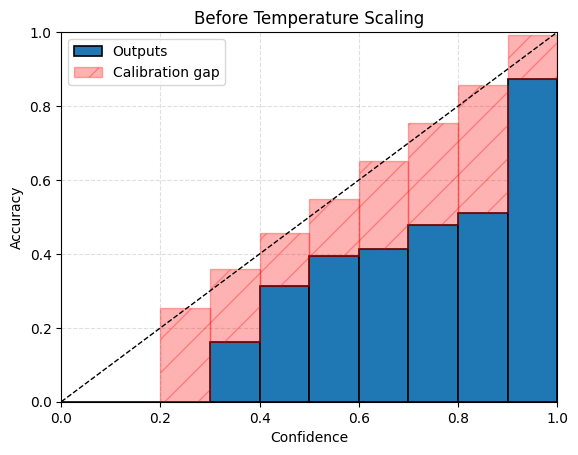

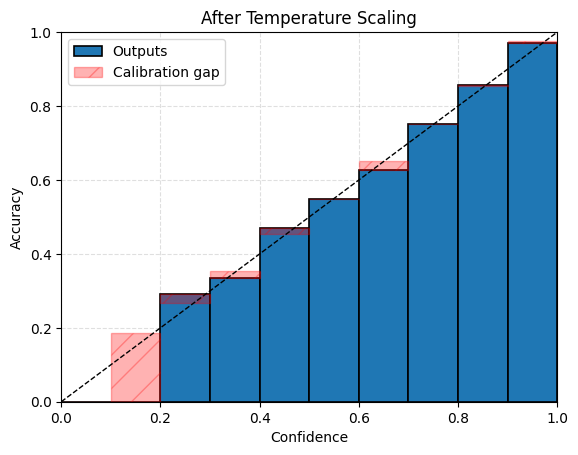

In [63]:
diagram1 = compute_reliability_diagram(x_test_before, y_test)
plot_reliability_diagram(diagram1, "Before Temperature Scaling")
diagram2 = compute_reliability_diagram(x_test_predicted, y_test)
plot_reliability_diagram(diagram2, "After Temperature Scaling")

In [64]:
tf.__version__

'2.20.0'